# EV Charging Data and CDR Analysis

In [1]:
print('ok')

ok


In [2]:
import numpy as np
import scipy as sp
import operator
import psycopg2
import folium as flm
import string
import mysql.connector as mdb
import pandas as pd
import json
import datetime
import folium
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import shapely as shp
import matplotlib.gridspec as gridspec
from shapely.geometry import Polygon
from pprint import pprint
from descartes.patch import PolygonPatch
#import shapefile 
%matplotlib inline
#matplotlib.rc('text', usetex=True)
matplotlib.rcParams.update({'font.size': 18})
matplotlib.rcParams.update({'legend.fontsize': 16})
from IPython.display import HTML

def inline_map(map1):
    map1._build_map()
    return HTML('<iframe srcdoc="{srcdoc}" style="width: 100%; height: 400px; border: none"></iframe>'.format(srcdoc=map1.HTML.replace('"', '&quot;')))

def embed_map(map1, path="map.html"):
    map1.create_map(path=path)
    return HTML('<iframe src="files/{path}" style="width: 100%; height: 400px; border: none"></iframe>'.format(path=path))

from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

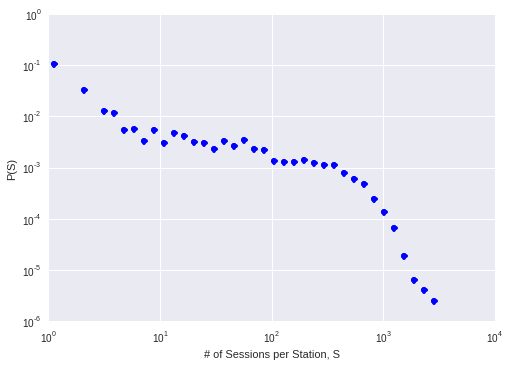

In [11]:
con = mdb.connect(host="localhost",user="emre",passwd="Kara1234",database="evdata")
cursor = con.cursor()
cursor.execute("""SELECT 
COUNT(EVENT_ID) FROM 
sessiondata GROUP 
BY EVSE_ID""")
import seaborn as sns
sns.set_style('darkgrid')
x = np.array([float(count[0]) for count in cursor])
con.close()
n, b = np.histogram(x, bins = np.logspace(0,3.5,40), density = True)
b=(b[:-1]+b[1:])/2
plt.figure()
plt.loglog(b,n,'bo',markerfacecolor = 'b',label = 'EVENTS')
plt.xlabel('# of Sessions per Station, S')
plt.ylabel('P(S)')
plt.show()

1465803
[ 0.]


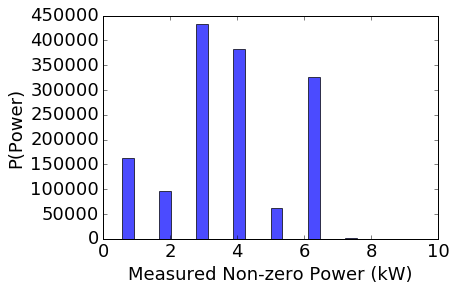

In [25]:
x = np.array([float(row['power']) for row in rows])
con.close()
print(len(x))
n, b = np.histogram(x, bins = np.linspace(0,10,10), density = False )
print(np.linspace(0,30,1))
b=(b[:-1]+b[1:])/2


bar_width = 0.35

opacity = 0.7
plt.figure()
rects1 = plt.bar(b, n, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Power')



#plt.plot(b,n,'ro',label = 'EVENTS')
plt.xlabel('Measured Non-zero Power (kW)')
plt.ylabel('P(Power)')
plt.show()

In [33]:
query_event_significance="""
SELECT DISTINCT PORT_TYPE, COUNT(DISTINCT(EVENT_ID)) from sessiondata GROUP BY PORT_TYPE""";

con = mdb.connect(host="localhost",user="emre",passwd="Kara1234",db="evdata")
cur = con.cursor(dictionary=True)
cur.execute(query_event_significance)
rows = cur.fetchall()
print(rows)


[{'COUNT(DISTINCT(EVENT_ID))': 675, 'PORT_TYPE': ''}, {'COUNT(DISTINCT(EVENT_ID))': 22881, 'PORT_TYPE': 'L1'}, {'COUNT(DISTINCT(EVENT_ID))': 626113, 'PORT_TYPE': 'L2'}, {'COUNT(DISTINCT(EVENT_ID))': 568, 'PORT_TYPE': 'L3'}]


In [2]:
res=np.array([])
var=np.array([0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,90,100])
for num in var:
    query_event_significance="""
    SELECT  sublap, SUM(totalCount) tc
    FROM (
      SELECT  DATE(sessiondata.SESSION_START_DATE) Date, mindata.sublap sublap, COUNT(DISTINCT sessiondata.EVENT_ID) totalCount
      FROM    sessiondata
      INNER JOIN mindata on sessiondata.EVENT_ID=mindata.EVENT_ID
      WHERE sessiondata.ENERGY > 0
            AND minute(sessiondata.SESSION_LENGTH)>1 
            AND YEAR(sessiondata.SESSION_END_DATE) = 2013
            AND YEAR(sessiondata.SESSION_START_DATE) = 2013
      GROUP   BY  DATE(sessiondata.SESSION_START_DATE),mindata.sublap
      ) s   WHERE totalCount >"""+ str(num-1)+' GROUP BY sublap';

    con = mdb.connect(host="localhost",user="root",passwd="",db="evdata")
    with con:
        cur = con.cursor(mdb.cursors.DictCursor)
        cur.execute(query_event_significance)
    rows = cur.fetchall()
    y = np.array([float(rows[i]['tc']) for i in xrange(len(rows))])
    res=np.append(res,np.sum(y))






OperationalError: (2006, 'MySQL server has gone away')

[ 554486.  552311.  548954.  542184.  530134.  517638.  507894.  500661.
  493165.  486582.  481839.  477162.  472551.  468845.  465917.  452518.
  445150.]
[ 554486.  552311.  548954.  542184.  530134.  517638.  507894.  500661.
  493165.  486582.  481839.  477162.  472551.  468845.  465917.  452518.
  445150.]


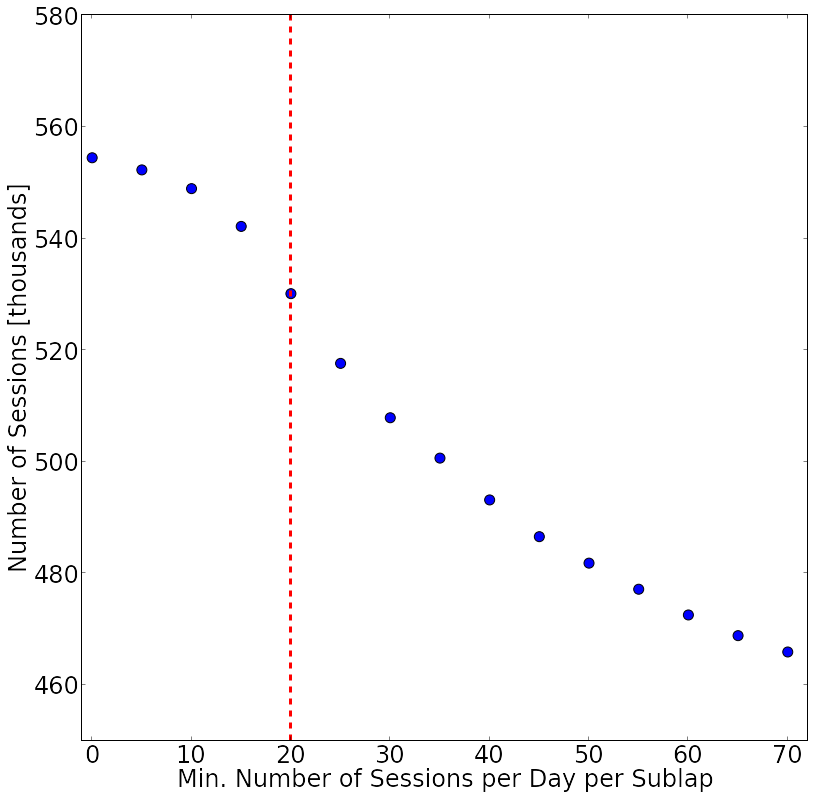

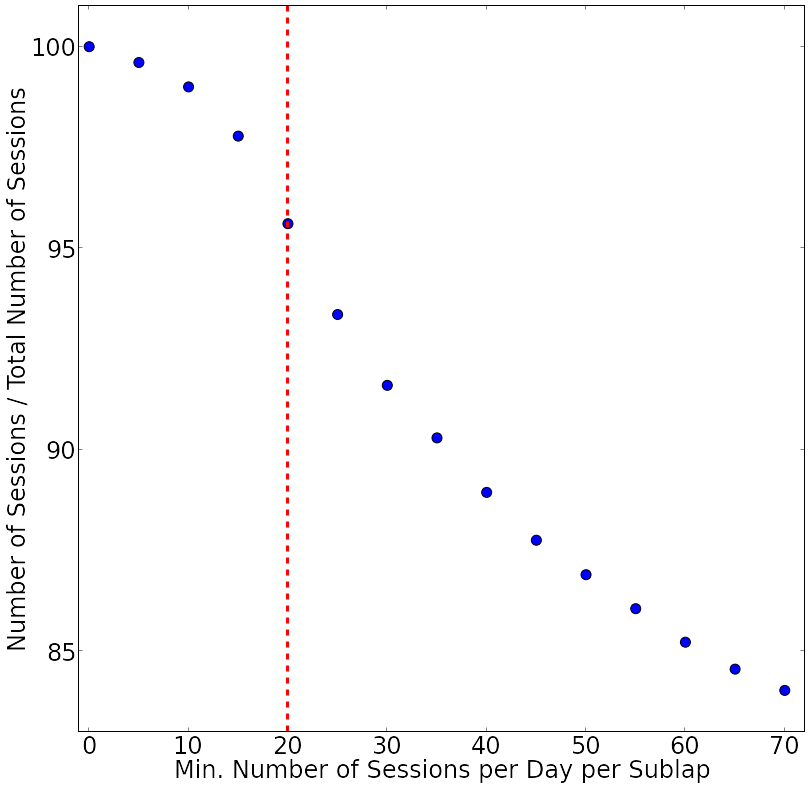

In [44]:
print res
plt.figure(figsize=(5, 5))
plt.scatter(var,res/1000,s=100)
plt.plot([20,20],[450,580],'--r',linewidth=3.0)
plt.xlabel('Min. Number of Sessions per Day per Sublap')
plt.ylabel('Number of Sessions [thousands]')
plt.xlim((-1,72))
plt.ylim((450,580))
plt.savefig('emre_total.png',dpi=300)

print res
plt.figure(figsize=(5, 5))
plt.scatter(var,res/res[0]*100,s=100)
plt.plot([20,20],[83,101],'--r',linewidth=3.0)
plt.xlabel('Min. Number of Sessions per Day per Sublap')
plt.ylabel('Number of Sessions / Total Number of Sessions')
plt.xlim((-1,72))
plt.ylim((83,101))
plt.savefig('emre_ratio.png',dpi=300)

In [15]:
con = mdb.connect(host="localhost",user="root",passwd="",db="evdata")
with con:
    cur = con.cursor(mdb.cursors.DictCursor)
#  Energy Delivered / Session Length in hrs > 7 kW for port types L1 and L2 and >35 kW for port type L3
    cur.execute("""SELECT EVSE_ID as evse,
                    concat(SESSION_START_DATE,' ',SESSION_START_TIME) as startdate,
                    concat(SESSION_END_DATE,' ',SESSION_END_TIME) as enddate,
                    CATEGORY
                    FROM sessiondata 
                    WHERE ENERGY>0 
                        AND minute(SESSION_LENGTH)>1 
                        AND ENERGY/minute(SESSION_LENGTH)>0.12
                        AND EVSE_ID >0
                        AND YEAR(SESSION_END_DATE) = 2013
                        AND YEAR(SESSION_START_DATE) = 2013
                    ORDER BY EVSE_ID, startdate, enddate""")
    #                    ,concat(SESSION_END_DATE,' ',SESSION_END_TIME) as enddate, 
    # minute(SESSION_LENGTH)
#    cur.execute("""SELECT ORG_ID as evse, concat(SESSION_START_DATE,' ',SESSION_START_TIME) as date FROM sessiondata ORDER BY ORG_ID, date""")
    rows = cur.fetchall()
con.close()
# print rows[0:10]
startdata = dict()
enddata = dict()
categ = dict()
for r in rows:
    evseid = int(r['evse'])
    stimet = datetime.strptime(r['startdate'], '%Y-%m-%d %H:%M:%S')
    etimet = datetime.strptime(r['enddate'], '%Y-%m-%d %H:%M:%S')
    if evseid in startdata.keys():
        startdata[evseid].append(stimet)
        enddata[evseid].append(etimet)
    else:
        startdata[evseid] = [stimet]
        enddata[evseid] = [etimet]
    category = r['CATEGORY']
    if category in categ.keys():
        categ[evseid].append(category)
    else:
        categ[evseid] = category
stations = list(set([int(rows[i]['evse']) for i in xrange(len(rows))]))


ProgrammingError: 1045 (28000): Access denied for user 'root'@'localhost' (using password: NO)

In [13]:
plt.figure(figsize=(12,8))
chargecount = 0
for s in stations:
    if s==0:
        continue
    times = startdata[s]
#    print times
    interarrival = [ (startdata[s][x] - startdata[s][x-1]).total_seconds()/60 for x in xrange(1,len(startdata[s])) ]
#    print interarrival
    if len(interarrival)<365:
        continue
    chargecount += 1
#    b = np.logspace(np.log10(60),np.log10(60*24*7),10)
    b = np.linspace(1,60*24*7,24*7)
    n, b = np.histogram(interarrival, bins = b, density = False )
    b=(b[:-1]+b[1:])/2/60
    plt.plot(b,n,'-o',label = 'abc',alpha=0.75)

# print chargecount
#plt.loglog([60,60],[1e-8, 1],'k-')
#plt.loglog([60*24,60*24],[1e-8, 1],'k-')
#plt.loglog([60,60],[1, 1e3],'k-')
#plt.loglog([60*24,60*24],[1, 1e3],'k-')
plt.xlabel('Interarrival')
plt.ylabel('P(Interarrival)')
plt.xlim([0,24*4])
plt.ylim([0,400])

plt.show()

NameError: name 'stations' is not defined

368


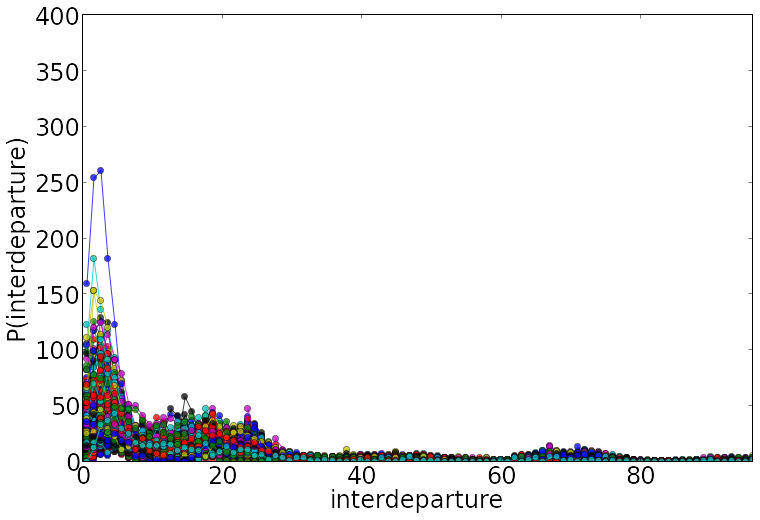

In [64]:
plt.figure(figsize=(12,8))
chargecount = 0
for s in stations:
    if s==0:
        continue
    interdeparture = [ (enddata[s][x] - enddata[s][x-1]).total_seconds()/60 for x in xrange(1,len(startdata[s])) ]
    if len(interdeparture)<365:
        continue
    chargecount += 1
#    b = np.logspace(np.log10(60),np.log10(60*24*7),10)
    b = np.linspace(1,60*24*7,24*7)
    n, b = np.histogram(interdeparture, bins = b, density = False )
    b=(b[:-1]+b[1:])/2/60
    plt.plot(b,n,'-o',label = 'abc',alpha=0.75)

print chargecount
#plt.loglog([60,60],[1e-8, 1],'k-')
#plt.loglog([60*24,60*24],[1e-8, 1],'k-')
#plt.loglog([60,60],[1, 1e3],'k-')
#plt.loglog([60*24,60*24],[1, 1e3],'k-')
plt.xlabel('interdeparture')
plt.ylabel('P(interdeparture)')
plt.xlim([0,24*4])
plt.ylim([0,400])

plt.show()

368


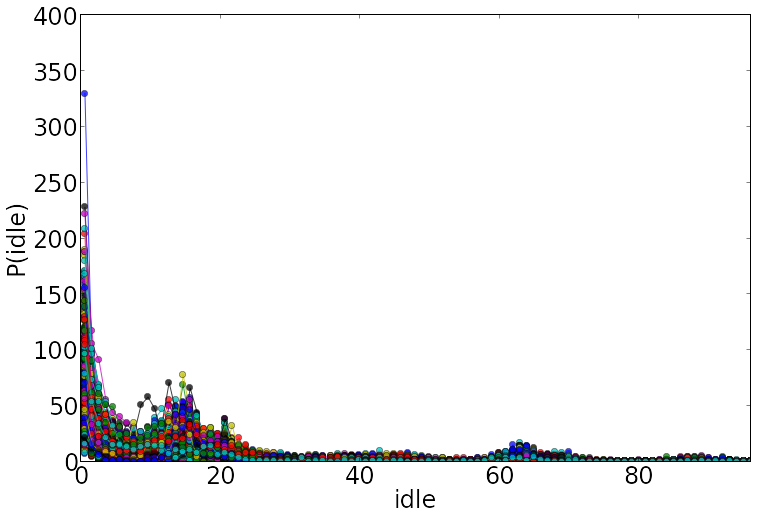

In [65]:
plt.figure(figsize=(12,8))
chargecount = 0
for s in stations:
    if s==0:
        continue
    idle = [ (startdata[s][x] - enddata[s][x-1]).total_seconds()/60 for x in xrange(1,len(startdata[s])) ]
    if len(idle)<365:
        continue
    chargecount += 1
#    b = np.logspace(np.log10(60),np.log10(60*24*7),10)
    b = np.linspace(1,60*24*7,24*7)
    n, b = np.histogram(idle, bins = b, density = False )
    b=(b[:-1]+b[1:])/2/60
    plt.plot(b,n,'-o',label = 'abc',alpha=0.75)

print chargecount
#plt.loglog([60,60],[1e-8, 1],'k-')
#plt.loglog([60*24,60*24],[1e-8, 1],'k-')
#plt.loglog([60,60],[1, 1e3],'k-')
#plt.loglog([60*24,60*24],[1, 1e3],'k-')
plt.xlabel('idle')
plt.ylabel('P(idle)')
plt.xlim([0,24*4])
plt.ylim([0,400])

plt.show()

#  organizational breakdown of the 3 peaks: 0-6 hr, 24hrs, 72hrs

369


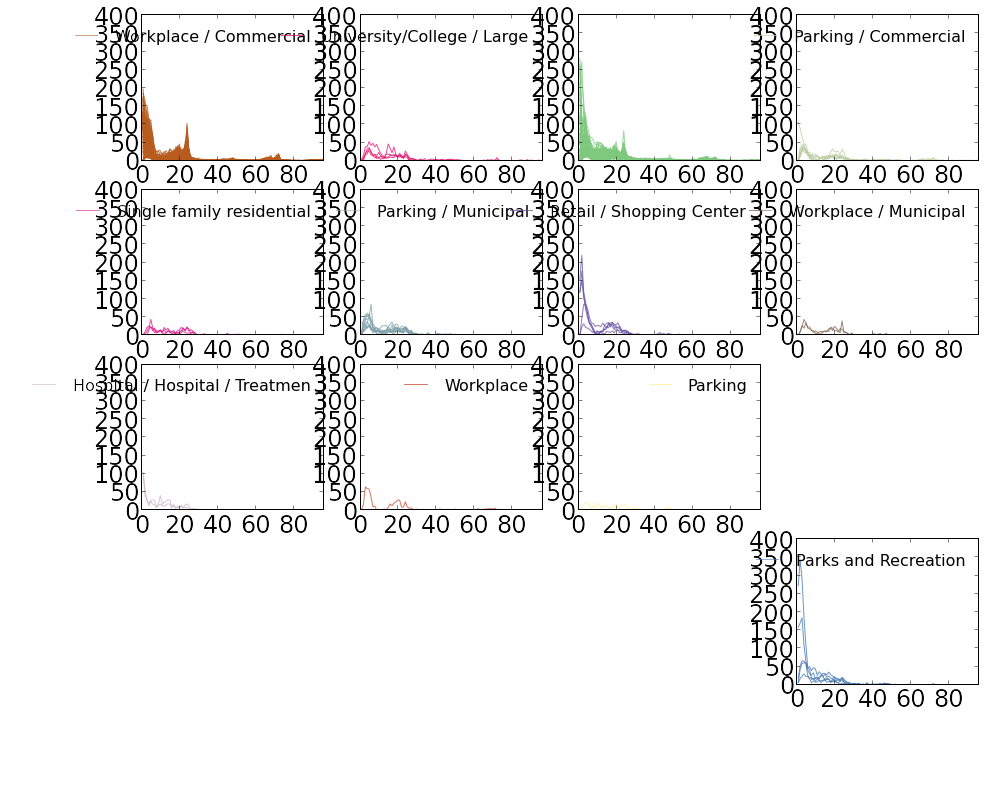

In [49]:
matplotlib.rcParams.update({'font.size': 24})
matplotlib.rcParams.update({'legend.fontsize': 16})
plt.figure(figsize=(15,12))
#gs = gridspec.GridSpec(4,4)

chargecount = 0
allcats = categ.values()
allcats = sorted(set(allcats))
catno = len(allcats)
# print len(allcats),allcats
colormap = [cm.Accent(float(j)/float(catno)) for j in xrange(catno)]
cmdict = dict()
i=0
for cat in allcats:
    cmdict[cat] = colormap[i]
    i+=1
    
haslabel = dict()
catindex = 0
for s in stations:
    if s==0:     # no station info
        continue
    times = data[s]
    category = categ[s]
    interarrival = [(data[s][x] - data[s][x-1]).total_seconds()/60 for x in xrange(1,len(data[s]))]
    idle = 
    if len(interarrival)<365:
        continue
    chargecount += 1
#    b = np.logspace(np.log10(60),np.log10(60*24*7),10)
    b = np.linspace(1,60*24*7,24*7)
    n, b = np.histogram(interarrival, bins = b, density = False )
    b=(b[:-1]+b[1:])/2/60
    if category in haslabel.keys():
        lab = ''
    else:
        haslabel[category] = catindex
        catindex += 1
        lab = category
        
#    plt.subplot(gs[haslabel[category]/4,haslabel[category]%4])
#    plt.subplot(gs[1,1])
    plt.subplot(4,4,haslabel[category])
    plt.plot(b,n,color=cmdict[category],label = lab,alpha=0.75)
    plt.xlim([0,24*4])
    plt.ylim([0,400])
    plt.legend(frameon=False)

print chargecount
#plt.loglog([60,60],[1e-8, 1],'k-')
#plt.loglog([60*24,60*24],[1e-8, 1],'k-')
#plt.loglog([60,60],[1, 1e3],'k-')
#plt.loglog([60*24,60*24],[1, 1e3],'k-')
# plt.xlabel('Interarrival')
# plt.ylabel('P(Interarrival)')


369


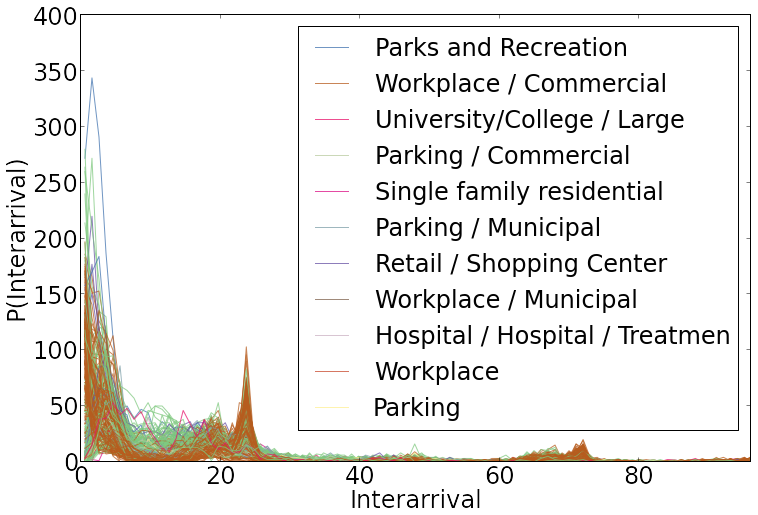

In [29]:
plt.figure(figsize=(12,8))
chargecount = 0
allcats = categ.values()
allcats = sorted(set(allcats))
catno = len(allcats)
# print len(allcats),allcats
colormap = [cm.Accent(float(j)/float(catno)) for j in xrange(catno)]
cmdict = dict()
i=0
for cat in allcats:
    cmdict[cat] = colormap[i]
    i+=1
    
haslabel = dict()
for s in stations:
    if s==0:     # no station info
        continue
    times = data[s]
    category = categ[s]
    interarrival = [(data[s][x] - data[s][x-1]).total_seconds()/60 for x in xrange(1,len(data[s]))]
    if len(interarrival)<365:
        continue
    chargecount += 1
#    b = np.logspace(np.log10(60),np.log10(60*24*7),10)
    b = np.linspace(1,60*24*7,24*7)
    n, b = np.histogram(interarrival, bins = b, density = False )
    b=(b[:-1]+b[1:])/2/60
    if category in haslabel.keys():
        lab = ''
    else:
        haslabel[category] = 1
        lab = category
    
    plt.plot(b,n,color=cmdict[category],label = lab,alpha=0.75)

print chargecount
#plt.loglog([60,60],[1e-8, 1],'k-')
#plt.loglog([60*24,60*24],[1e-8, 1],'k-')
#plt.loglog([60,60],[1, 1e3],'k-')
#plt.loglog([60*24,60*24],[1, 1e3],'k-')
plt.xlabel('Interarrival')
plt.ylabel('P(Interarrival)')
plt.xlim([0,24*4])
plt.ylim([0,400])
plt.legend()
plt.show()


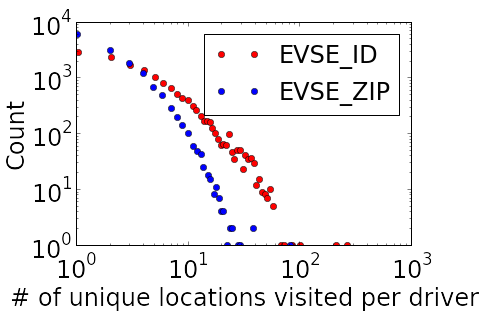

57333
85


In [3]:
# Let's take a look at the unique EVSE's visited per driver overall
con = mdb.connect(host="localhost",user="root",passwd="",db="evdata")
with con:
    cur = con.cursor(mdb.cursors.DictCursor)
    cur.execute("""SELECT distinct(DRIVER_ID) as driver,
                    count(distinct(EVSE_ID)) as evse_count
                    FROM sessiondata 
                    WHERE ENERGY>0 
                        AND minute(SESSION_LENGTH)>1 
                        AND DRIVER_ID >0
                        AND EVSE_ID >0
                        AND YEAR(SESSION_END_DATE) = 2013
                        AND YEAR(SESSION_START_DATE) = 2013
                    GROUP BY driver ORDER BY evse_count""")
    rows = cur.fetchall()
    cur = con.cursor(mdb.cursors.DictCursor)
    cur.execute("""SELECT distinct(DRIVER_ID) as driver,
                    count(distinct(EVSE_ZIP)) as evse_count
                    FROM sessiondata 
                    WHERE ENERGY>0 
                        AND minute(SESSION_LENGTH)>1 
                        AND DRIVER_ID >0
                        AND EVSE_ZIP >0
                        AND YEAR(SESSION_END_DATE) = 2013
                        AND YEAR(SESSION_START_DATE) = 2013
                    GROUP BY driver ORDER BY evse_count""")
    rows_zip = cur.fetchall()
con.close()
#  Energy Delivered / Session Length in hrs > 7 kW for port types L1 and L2 and >35 kW for port type L3
evseCount = dict()
evseZipCount = dict()

for r in rows:
    evseCount[int(r['driver'])] = int(r['evse_count'])
for r2 in rows_zip:
    evseZipCount[int(r2['driver'])] = int(r2['evse_count'])

x = np.array(evseCount.values())
x2 = np.array(evseZipCount.values())
n, b = np.histogram(x, bins = np.logspace(0, np.log10(max(x)),100), density = False)
n2, b2 = np.histogram(x2, bins = np.logspace(0, np.log10(max(x2)),100), density = False )

b=(b[:-1]+b[1:])/2
b2=(b2[:-1]+b2[1:])/2
plt.figure()
plt.loglog(b,n,'ro',label='EVSE_ID')
plt.plot(b2,n2,'bo',label='EVSE_ZIP')
plt.xlabel('# of unique locations visited per driver')
plt.ylabel('Count')
plt.legend()
plt.show()

print max(evseZipCount.iteritems(), key=operator.itemgetter(1))[0] 
print evseZipCount[max(evseZipCount.iteritems(), key=operator.itemgetter(1))[0]]


In [2]:
# Let's see how many unique zip codes are visited per day  
con = mdb.connect(host="localhost",user="emre",passwd="Kara1234",db="evdata")
with con:
    cur = con.cursor(mdb.cursors.DictCursor)
    cur.execute("""SELECT DRIVER_ID as driver, SESSION_START_DATE as start,
                    count(distinct(EVSE_ZIP)) as evse_count
                    FROM sessiondata 
                    WHERE ENERGY>0 
                        AND minute(SESSION_LENGTH)>1
                        AND EVSE_ZIP >0
                        AND DRIVER_ID > 0
                        AND YEAR(SESSION_END_DATE) = 2013
                        AND YEAR(SESSION_START_DATE) = 2013
                    GROUP BY driver, start ORDER BY evse_count""")
    rows = cur.fetchall()
con.close()
#  Energy Delivered / Session Length in hrs > 7 kW for port types L1 and L2 and >35 kW for port type L3
evseZipPerDayCount = dict()
for r in rows:
    evseZipPerDayCount[int(r['driver'])] = int(r['evse_count'])


x = np.array(evseZipPerDayCount.values())
n, b = np.histogram(x, bins = np.logspace(0, np.log10(max(x)),10), density = False )
b=(b[:-1]+b[1:])/2
plt.figure()
plt.loglog(b,n,'ro')
plt.xlabel('# of unique zip codes visited per driver per day')
plt.ylabel('Count')
plt.show()
# Whic driver is the champion?
print(max(evseZipPerDayCount.iteritems(), key=operator.itemgetter(1))[0])
print(evseZipPerDayCount[max(evseZipPerDayCount.iteritems(), key=operator.itemgetter(1))[0]])

AttributeError: __exit__

In [3]:
# Set a bound for number of uniqe zip codes visited and the number of maximum events per day
zip_bound=2
ec_bound=2
# Get top X many Drivers in terms of unique ZIP codes visited per day
con = mdb.connect(host="localhost",user="emre",passwd="Kara1234",db="evdata")
cur = con.cursor(dictionary=True)
cur.execute("""SELECT t1.driver,t1.zip_count,t1.start,t1.event_count from (SELECT DRIVER_ID as driver, 
                SESSION_START_DATE as start, MONTH(SESSION_START_DATE) as month,
                DAY(SESSION_START_DATE) as day,
                YEAR(SESSION_START_DATE) as year,
                count(distinct(EVSE_ZIP)) as zip_count,
                count(distinct(EVENT_ID)) as event_count
                FROM sessiondata 
                WHERE ENERGY>0 
                    AND minute(SESSION_LENGTH)>1
                    AND EVSE_ZIP >0
                    AND SESSION_START_DATE=SESSION_END_DATE
                    AND DRIVER_ID >0
                    AND YEAR(SESSION_END_DATE) = 2013
                    AND YEAR(SESSION_START_DATE) = 2013
                GROUP BY driver, start) as t1 WHERE t1.zip_count=%s and t1.event_count=%s"""%(zip_bound,ec_bound))
rowsChamp = cur.fetchall()
con.close()

driversWithVisits= np.array([(int(rowsChamp[i]['driver']),rowsChamp[i]['start'],float(rowsChamp[i]['zip_count'])) for i in range(len(rowsChamp))])


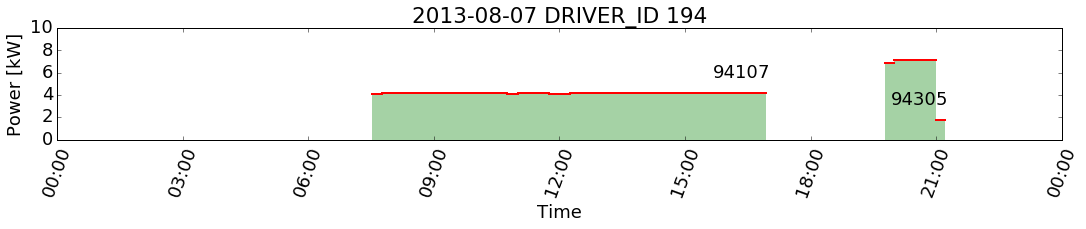

OperationalError: FATAL:  password authentication failed for user "emre"
FATAL:  password authentication failed for user "emre"


In [8]:

dri=driversWithVisits[12]
con = mdb.connect(host="localhost",user="emre",passwd="Kara1234",db="evdata")
cur = con.cursor(dictionary=True)
cur.execute("""SELECT EVENT_ID, SESSION_START_TIME,SESSION_END_TIME,SESSION_LENGTH as duration,ENERGY,EVSE_ZIP
                FROM sessiondata 
                WHERE ENERGY>0 
                    AND minute(SESSION_LENGTH)>1
                    AND EVSE_ZIP >0
                    AND DRIVER_ID="%s" 
                    AND SESSION_START_DATE >="%s" AND SESSION_END_DATE <"%s" ORDER BY SESSION_START_TIME;"""%(str(dri[0]),dri[1].strftime('%Y-%m-%d'),(dri[1]+datetime.timedelta(days=1)).strftime('%Y-%m-%d')))
res = cur.fetchall()
con.close()
session_date=dri[1]

zip_codes_visited=[]
energy_put_in=[]
x = np.array([(int(res[i]['EVENT_ID']),int(res[i]['EVSE_ZIP']),float(res[i]['ENERGY']),float(res[i]['duration'].total_seconds()/60),session_date+res[i]['SESSION_START_TIME'],session_date+res[i]['SESSION_END_TIME']) for i in range(len(res))])
plt.figure(figsize=(18, 2))

for elem in x:
    con = mdb.connect(host="localhost",user="emre",passwd="Kara1234",db="evdata")
    cur = con.cursor(dictionary=True)
    cur.execute("""SELECT INTERVAL_START_DATE,INTERVAL_START_TIME,INTERVAL_STOP_DATE,INTERVAL_STOP_TIME,AVERAGE_POWER
                    FROM mindata 
                    WHERE EVENT_ID="%d";"""%(elem[0]))
    res = cur.fetchall()
    zip_codes_visited=np.append(zip_codes_visited,elem[1])
    energy_put_in=np.append(energy_put_in,elem[2])
    dat = np.array([(datetime.datetime.combine(res[i]['INTERVAL_START_DATE'], datetime.datetime.min.time())+res[i]['INTERVAL_START_TIME'], datetime.datetime.combine(res[i]['INTERVAL_STOP_DATE'],datetime.datetime.min.time())+res[i]['INTERVAL_STOP_TIME'], float(res[i]['AVERAGE_POWER'])) for i in range(len(res))])
    for element in dat:
        plt.plot([element[0],element[1]],[element[2],element[2]],'-r',linewidth=2.0)
        plt.fill_between([element[0],element[1]],[element[2],element[2]], facecolor='green', alpha=0.35,linewidth=0.0)
        #print element[0].strftime('%Y-%m-%d %HH:%MM')
    plt.annotate(str(elem[1]), (mdates.date2num(element[0]), element[2]), xytext=(-45, 15), 
            textcoords='offset points')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=70)
plt.title(dri[1].strftime('%Y-%m-%d')+' DRIVER_ID '+str(dri[0]))
plt.xlabel('Time')
plt.ylabel('Power [kW]')
plt.gca().set_ylim([0,10])
plt.gca().set_xlim(dri[1],dri[1]+datetime.timedelta(days=1))

plt.show()

visited_zips=str(np.array_str(zip_codes_visited)).replace('[','').replace(']','').replace('.',',').replace(' ','')[:-1]

# connect over the ssh tunnel to Michaelangelo's psql server 
conn = psycopg2.connect(database="bgrid", user="emre", password="Kara1234", host="localhost", port="5433")

# Open a cursor to perform database operations
cur = conn.cursor()

# GETTING POLYGON DATA FROM SWITCH-DB2 and WRITE IT TO A LOCAL JSON FILE FOR FOLIUM
getJSON='''SELECT row_to_json(fc)
FROM ( SELECT 'FeatureCollection' As type, array_to_json(array_agg(f)) As features
FROM (SELECT 'Feature' As type
   , ST_AsGeoJSON(lg.geom)::json As geometry
    , row_to_json(lp) As properties
  FROM gis_data.census_zcta As lg
       INNER JOIN (SELECT aland10, geoid10 FROM gis_data.census_zcta where CAST (geoid10 AS INTEGER) IN (%s)) As lp
      ON lg.geoid10 = lp.geoid10  ) As f )  As fc;'''%visited_zips
cur.execute(getJSON)
data=cur.fetchall()
f = open('./combined_data.json','w')
f.write(str(data[0][0])) 
f.close()


# GET CENTROIDS OF VISITED ZIP CODES
cur = conn.cursor()
visited_zips=str(np.array_str(zip_codes_visited)).replace('[','').replace(']','').replace('.',',').replace(' ','')[:-1]
# GETTING DATA FROM SWITCH-DB2 and VISUALIZING IT USING FOLIUM (PSQL 9.1)
getJSON='''SELECT ST_X(ST_CENTROID(geom)) as X,ST_Y(ST_CENTROID(geom)) as Y  from gis_data.census_zcta where CAST (geoid10 AS INTEGER) IN (%s)'''%visited_zips
cur.execute(getJSON)
centroids=cur.fetchall()

#BIND ALL JSON FILES
map1 = folium.Map(location=[37.6, -122.4], zoom_start=11)
cnt=0
#map1.geo_json(geo_path='./combined_data.json',line_color='#FF0000', line_opacity=1, fill_opacity=0)
pts=([(points[1],points[0]) for points in centroids])
for points in pts:
    print(points)
    map1.simple_marker(points, popup=str(cnt)+':'+str(zip_codes_visited[cnt]))
    cnt=cnt+1   

i=0
while i<cnt-1:        
    map1.line([pts[i],pts[i+1]], line_color='#00CC00', line_weight=5,line_opacity=0.8)    
    i=i+1
map1.create_map(path='map7.html')
embed_map(map1,path='map7.html')

<function matplotlib.pyplot.show>

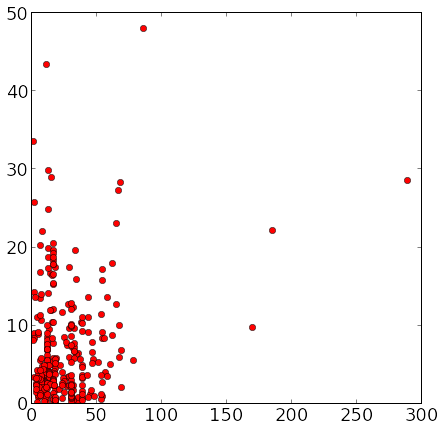

In [7]:
dist=[]
ener=[]

for dri in driversWithVisits[:300]:
    con = mdb.connect(host="localhost",user="root",passwd="",db="evdata")
    with con:
        cur = con.cursor(mdb.cursors.DictCursor)
        cur.execute("""SELECT EVENT_ID, SESSION_START_TIME,SESSION_END_TIME,SESSION_LENGTH as duration,ENERGY,EVSE_ZIP
                        FROM sessiondata 
                        WHERE ENERGY>0 
                            AND minute(SESSION_LENGTH)>1
                            AND EVSE_ZIP >0
                            AND DRIVER_ID="%s" 
                            AND SESSION_START_DATE >="%s" AND SESSION_END_DATE <"%s" ORDER BY SESSION_START_TIME;"""%(str(dri[0]),dri[1].strftime('%Y-%m-%d'),(dri[1]+datetime.timedelta(days=1)).strftime('%Y-%m-%d')))
        res = cur.fetchall()
    con.close()
    session_date=dri[1]

    zip_codes_visited=[]
    energy_put_in=[]
    x = np.array([(int(res[i]['EVENT_ID']),int(res[i]['EVSE_ZIP']),float(res[i]['ENERGY']),float(res[i]['duration'].total_seconds()/60),session_date+res[i]['SESSION_START_TIME'],session_date+res[i]['SESSION_END_TIME']) for i in xrange(len(res))])
    for elem in x:
            zip_codes_visited=np.append(zip_codes_visited,elem[1])
            energy_put_in=np.append(energy_put_in,elem[2])
    visited_zips=str(np.array_str(zip_codes_visited)).replace('[','').replace(']','').replace('.',',').replace(' ','')[:-1]
    # GET CENTROIDS OF VISITED ZIP CODES
    ## Set up an ssh-tunnel to the database that is in EMAC3 locally (PSQL 9.3)

    # connect over this tunnel 
    conn = psycopg2.connect(database="bgrid", user="emre", password='Kara1234', host="localhost", port="5433")

    # Open a cursor to perform database operations
    cur = conn.cursor()
    visited_zips=str(np.array_str(zip_codes_visited)).replace('[','').replace(']','').replace('.',',').replace(' ','')[:-1]
    # GETTING DATA FROM SWITCH-DB2 and VISUALIZING IT USING FOLIUM (PSQL 9.1)
    getJSON='''SELECT ST_X(ST_CENTROID(geom)) as X,ST_Y(ST_CENTROID(geom)) as Y  from gis_data.census_zcta where CAST (geoid10 AS INTEGER) IN (%s)'''%visited_zips
    cur.execute(getJSON)
    centroids=cur.fetchall()
    pts=([(points[1],points[0]) for points in centroids])
    if len(pts)==2:
        dist=np.append(dist,haversine(pts[0][1],pts[0][0],pts[1][1],pts[1][0]))
        ener=np.append(ener,energy_put_in[1])
#print dist
#print ener
plt.figure(figsize=(7, 7))
plt.plot(dist,ener,'ro')
plt.show


<function matplotlib.pyplot.show>

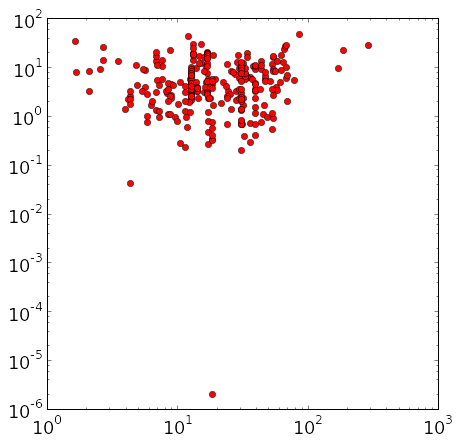

In [8]:
plt.figure(figsize=(7, 7))
plt.loglog(dist,ener,'ro')
plt.show


In [10]:
od = np.genfromtxt("./evWork/DataDump/DataDump/ods/sfbay_zipod_0_1.txt",
                   skip_header = True,
                   delimiter = ",")

conn = psycopg2.connect(database="bgrid", user="emre", password='Kara1234', host="localhost", port="5433")

origin_distance_flow= np.empty((0,3), float)
for destination in od:
    if destination[1]==94043:
        cur = conn.cursor()
        getJSON='''SELECT ST_X(ST_CENTROID(a.geom)),ST_Y(ST_CENTROID(a.geom)), ST_X(ST_CENTROID(b.geom)), ST_Y(ST_CENTROID(b.geom))
                    from gis_data.census_zcta a, gis_data.census_zcta b 
                    WHERE CAST (a.geoid10 AS INTEGER) = 94043 and CAST (b.geoid10 AS INTEGER)=%s'''%(str(destination[0]))

        cur.execute(getJSON)
        pts=cur.fetchall()
        origin_distance_flow=np.vstack((origin_distance_flow,np.array([destination[0],haversine(pts[0][0],pts[0][1],pts[0][2],pts[0][3]),destination[2]])))

        # Open a cursor to perform database operations  


In [14]:
# Get top X many Drivers in terms of unique ZIP codes visited per day
con = mdb.connect(host="localhost",user="root",passwd="",db="evdata")
with con:
    cur = con.cursor(mdb.cursors.DictCursor)
    cur.execute("""SELECT t1.driver,t1.zip_count,t1.start, t1.event,t1.energy from (SELECT ENERGY as energy,EVENT_ID as event, DRIVER_ID as driver, SESSION_START_DATE as start, MONTH(SESSION_START_DATE) as month,
                    DAY(SESSION_START_DATE) as day,
                    YEAR(SESSION_START_DATE) as year,
                    count(distinct(EVSE_ZIP)) as zip_count
                    FROM sessiondata 
                    WHERE ENERGY>0 
                        AND minute(SESSION_LENGTH)>1
                        AND EVSE_ZIP = 94043
                        AND SESSION_START_DATE=SESSION_END_DATE
                        AND HOUR(SESSION_START_TIME)<9
                        AND DRIVER_ID >0
                        AND YEAR(SESSION_END_DATE) = 2013
                        AND YEAR(SESSION_START_DATE) = 2013
                    GROUP BY driver, start) as t1 WHERE t1.zip_count=1""")
    rowsChamp = cur.fetchall()
con.close()

events= np.array([int(rowsChamp[i]['energy']) for i in xrange(len(rowsChamp))])
#print driversWith3Visits

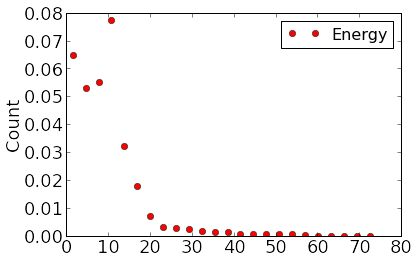

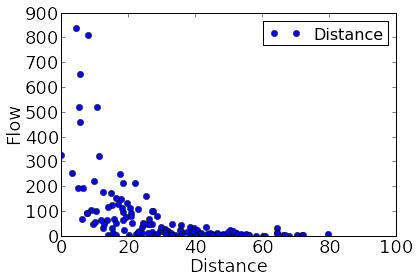

In [18]:
x = events
#x2 = origin_distance_flow[:,1]*(/np.sum(origin_distance_flow[:,2]))
n, b = np.histogram(x, bins = np.linspace(0, max(x),25), density = True)
#n2, b2 = np.histogram(x2, bins = np.linspace(0, max(x2),25), density = True )

b=(b[:-1]+b[1:])/2
#b2=(b2[:-1]+b2[1:])/2
plt.figure()
plt.plot(b,n,'ro',label='Energy')
plt.ylabel('Count')
plt.legend()
plt.show()

plt.figure()
plt.plot(origin_distance_flow[:,1],origin_distance_flow[:,2],'bo',label='Distance')
plt.ylabel('Flow')
plt.xlabel('Distance')
plt.xlim([0,100])
plt.legend()
plt.show()


In [9]:
visited_zips=str(np.array_str(origin_distance_flow[:,0])).replace('[','').replace(']','').replace('.',',').replace(' ','')[:-1]

# connect over this tunnel 
conn = psycopg2.connect(database="bgrid", user="emre", password='Kara1234', host="localhost", port="5433")

# Open a cursor to perform database operations
cur = conn.cursor()

# GETTING POLYGON DATA FROM SWITCH-DB2 and WRITE IT TO A LOCAL JSON FILE FOR FOLIUM
getJSON='''SELECT row_to_json(fc)
FROM ( SELECT 'FeatureCollection' As type, array_to_json(array_agg(f)) As features
FROM (SELECT 'Feature' As type
   , ST_AsGeoJSON(lg.geom)::json As geometry
    , row_to_json(lp) As properties
  FROM gis_data.census_zcta As lg
       INNER JOIN (SELECT aland10, geoid10 FROM gis_data.census_zcta where CAST (geoid10 AS INTEGER) IN (%s)) As lp
      ON lg.geoid10 = lp.geoid10  ) As f )  As fc;'''%visited_zips
cur.execute(getJSON)
data=cur.fetchall()
f = open('./combined_data2.json','w')
f.write(data[0][0]) 
f.close()

flow=dict((el[0],el[2]) for el in origin_distance_flow)

# GET CENTROIDS OF VISITED ZIP CODES
cur = conn.cursor()
# GETTING DATA FROM SWITCH-DB2 and VISUALIZING IT USING FOLIUM (PSQL 9.1)
getJSON='''SELECT ST_X(ST_CENTROID(geom)) as X,ST_Y(ST_CENTROID(geom)) as Y, geoid10   
        from gis_data.census_zcta where CAST (geoid10 AS INTEGER) IN (%s)'''%visited_zips
cur.execute(getJSON)
centroids=cur.fetchall()
getJSON='''SELECT ST_X(ST_CENTROID(geom)) as X,ST_Y(ST_CENTROID(geom)) as Y 
        from gis_data.census_zcta where CAST (geoid10 AS INTEGER)=94043'''
cur.execute(getJSON)
google=cur.fetchall()
google=google[0]
#print np.max(flow.values())
#BIND ALL JSON FILES
map1 = folium.Map(location=[37.6, -122.4], zoom_start=11,tiles='Stamen Toner')
cnt=0
#print centroids[0]
for points in centroids:
    map1.line([[points[1],points[0]],[google[1],google[0]]], line_color='#FFA500', line_weight=flow[int(points[2])]/80,line_opacity=1)   
map1.geo_json(geo_path='./combined_data2.json',fill_color='#6289AD', fill_opacity=0.3, line_color='#0E2437',line_opacity=0.9)
map1.create_map(path='mapall1.html')
embed_map(map1,path='mapall1.html')
    

NameError: name 'origin_distance_flow' is not defined

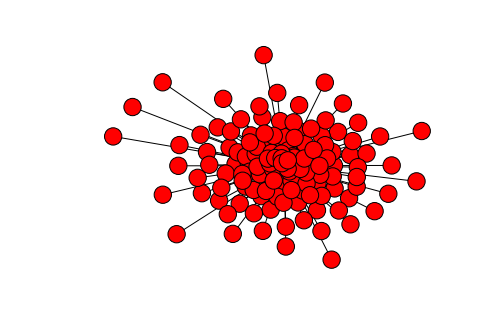

In [67]:
import networkx as nx
import matplotlib.pyplot as plt

G=nx.Graph()
G.add_nodes_from(origin_distance_flow[:,0])
for elem in origin_distance_flow:
    G.add_edge(elem[0],94043,weight=elem[2],length=elem[1])
nx.draw(G)
plt.show()
#print G.edge

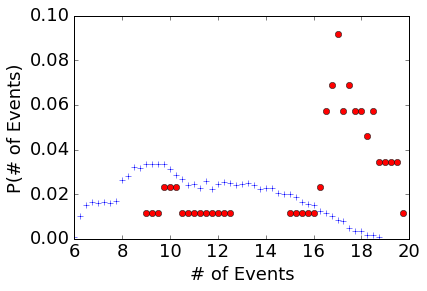

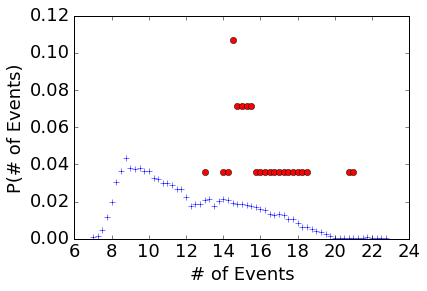

[ array([ 0.00087374,  0.00131062,  0.00480559,  0.01179554,  0.01965924,
        0.03058104,  0.03669725,  0.04325033,  0.03800786,  0.03757099,
        0.03800786,  0.03626038,  0.03626038,  0.0327654 ,  0.03189166,
        0.03014417,  0.03014417,  0.02883355,  0.02664919,  0.02664919,
        0.02271734,  0.01747488,  0.0187855 ,  0.0187855 ,  0.02096986,
        0.02140673,  0.01747488,  0.02009611,  0.02140673,  0.02096986,
        0.01922237,  0.0187855 ,  0.0187855 ,  0.01834862,  0.01747488,
        0.01703801,  0.01616426,  0.01572739,  0.01310616,  0.01266929,
        0.01310616,  0.01266929,  0.01048493,  0.01048493,  0.00830057,
        0.00611621,  0.00655308,  0.00524246,  0.00436872,  0.00349498,
        0.00262123,  0.00131062,  0.00043687,  0.00043687,  0.00043687,
        0.00043687,  0.00043687,  0.00043687,  0.00043687,  0.00087374,
        0.00043687,  0.00043687,  0.00043687,  0.00043687])
 array([ 0.03571429,  0.03571429,  0.03571429,  0.10714286,  0.07142857,
 

In [3]:
# Don't need the function below, but it seems usefull.
def roundTime(td=None, roundTo=60):
   """Round timedelta object to nearest 15 minutes"""
   if td == None : td = datetime.timedelta(seconds=0)
   seconds = td.total_seconds()
   # // is a floor division, not a comment on following line:
   rounding = (seconds+roundTo/2) // roundTo * roundTo
   return datetime.timedelta(seconds=rounding)

con = mdb.connect(host="localhost",user="emre",passwd="Kara1234",db="evdata")
cur = con.cursor(dictionary=True)
cur.execute('''SELECT DAY_TIME, COUNT
                    FROM DailyCount
                    WHERE EVSE_ID=10218
                    AND DAY_OF_WEEK=1
                    ORDER BY DAY_TIME''')
rows = cur.fetchall()
cur.execute('''SELECT DAY_TIME, COUNT
                    FROM DailyCount
                    WHERE EVSE_ID=10218
                    AND DAY_OF_WEEK=2
                    ORDER BY DAY_TIME''')
rows_week = cur.fetchall()
con.close()

dt_su=[row['DAY_TIME'].total_seconds() for row in rows]
count_su=[row['COUNT'] for row in rows]

dt_mo=[row['DAY_TIME'].total_seconds() for row in rows_week]
count_mo=[row['COUNT'] for row in rows_week]


plt.figure()
plt.plot(np.array(dt_su)/3600,count_su/np.sum(count_su),'ro',label = 'Sunday Counts')
plt.plot(np.array(dt_mo)/3600,count_mo/np.sum(count_mo),'b+',label = 'Monday Counts')
plt.xlabel('# of Events')
plt.ylabel('P(# of Events)')
plt.show()

con = mdb.connect(host="localhost",user="emre",passwd="Kara1234",db="evdata")
cur = con.cursor(dictionary=True)
cur.execute('''SELECT DAY_TIME, COUNT
                    FROM DailyCount
                    WHERE EVSE_ID=41443
                    AND DAY_OF_WEEK=1
                    ORDER BY DAY_TIME''')
rows = cur.fetchall()
cur.execute('''SELECT DAY_TIME, COUNT
                    FROM DailyCount
                    WHERE EVSE_ID=41443
                    AND DAY_OF_WEEK=2
                    ORDER BY DAY_TIME''')
rows_week = cur.fetchall()
con.close()

dt_su=[row['DAY_TIME'].total_seconds() for row in rows]
count_su=[row['COUNT'] for row in rows]

dt_mo=[row['DAY_TIME'].total_seconds() for row in rows_week]
count_mo=[row['COUNT'] for row in rows_week]


plt.figure()
plt.plot(np.array(dt_su)/3600, count_su/np.sum(count_su), 'ro', label = 'Sunday Counts')
plt.plot(np.array(dt_mo)/3600, count_mo/np.sum(count_mo), 'b+', label = 'Monday Counts')
plt.xlabel('# of Events')
plt.ylabel('P(# of Events)')
plt.show()

print(np.array([count_mo/np.sum(count_mo),count_su/np.sum(count_su)]))
print(np.transpose(np.hstack((np.array(count_mo/np.sum(count_mo)),np.array(count_su/np.sum(count_su))))))


In [45]:
# TABLE CREATION SCRIPTS FOR FUTURE DEBUGGING
"""
con = mdb.connect(host="localhost",user="emre",passwd="Kara1234",db="evdata")
cur = con.cursor(dictionary=True)

cur.execute('''CREATE TABLE DailyCount (
     id INT NOT NULL AUTO_INCREMENT,
     EVSE_ID INT NOT NULL,
     COUNT INT NOT NULL,
     DAY_TIME TIME NOT NULL,
     DAY_OF_WEEK INT NOT NULL,
     PRIMARY KEY (id))''') 
con.close()

con = mdb.connect(host="localhost",user="emre",passwd="Kara1234",db="evdata")
cur = con.cursor(dictionary=True)
cur.execute('''INSERT INTO DailyCount (EVSE_ID, COUNT, DAY_TIME, DAY_OF_WEEK)
                SELECT EVSE_ID, COUNT(AVERAGE_POWER) as COUNT,
                        SEC_TO_TIME(FLOOR((TIME_TO_SEC(INTERVAL_START_TIME)+450)/900)*900) as DAY_TIME,
                        DAYOFWEEK(INTERVAL_START_DATE) as DAY_OF_WEEK
                        FROM mindata
                        WHERE AVERAGE_POWER>0
                        GROUP BY EVSE_ID,DAY_OF_WEEK, DAY_TIME ORDER BY COUNT;''')
rows = cur.fetchall()
con.close()
"""